# Analyze PacBio CCSs
This notebook analyzes the PacBio CCSs that have been previously aligned and parsed with [alignparse](https://jbloomlab.github.io/alignparse/).

Import Python modules:

In [1]:
import os

import alignparse.targets

import altair as alt

import pandas as pd

import yaml

Get configuration information:

In [2]:
# If you are running notebook interactively rather than in pipeline that handles
# working directories, you may have to first `os.chdir` to appropriate directory.

with open("config.yaml") as f:
    config = yaml.safe_load(f)

Read in the PacBio runs:

In [3]:
pacbio_runs = (
    pd.read_csv(config["pacbio_runs"])
    .assign(subdir=lambda x: "results/process_ccs/" + x["run"])
    .rename(columns={"run": "pacbioRun"})
)

pacbio_runs

,library,pacbioRun,fastq,subdir
0,LibA,LibA-221107,/fh/fast/bloom_j/SR/ngs/pacbio/221102_Caelan_B...,results/process_ccs/LibA-221107
1,LibB,LibB-221107,/fh/fast/bloom_j/SR/ngs/pacbio/221102_Caelan_B...,results/process_ccs/LibB-221107


## Stats on CCS alignments
Read and plot the alignment stats from running `alignparse` on the PacBio CCSs:

In [4]:
readstats = pd.concat(
    [
        (
            pd.read_csv(os.path.join(row.subdir, "readstats.csv")).assign(
                pacbioRun=row.pacbioRun, library=row.library
            )
        )
        for row in pacbio_runs.itertuples()
    ],
    ignore_index=True,
)

readstats_chart = (
    alt.Chart(readstats)
    .encode(
        x="count:Q",
        y=alt.Y(
            "category:N",
            axis=alt.Axis(title=None),
        ),
        tooltip=readstats.columns.tolist(),
        facet=alt.Facet("pacbioRun:N", columns=2, title=None),
    )
    .mark_bar()
    .properties(width=250, height=50)
    .resolve_scale(x="independent", y="independent")
)

readstats_chart

alt.Chart(...)

## Visualize target to which reads are being aligned
Draw images of the target we're parsing:

/fh/fast/bloom_j/software/miniconda3/envs/dms-vep-pipeline-3/lib/python3.11/site-packages/Bio/GenBank/Scanner.py:1529: BiopythonParserWarning: Attempting to parse malformed locus line:
'LOCUS       PacBio_amplicon        1898 bp    DNA     linear   UNA 07-NOV-2022\n'
Found locus 'PacBio_amplicon' size '1898' residue_type 'DNA'
Some fields may be wrong.
  warnings.warn(


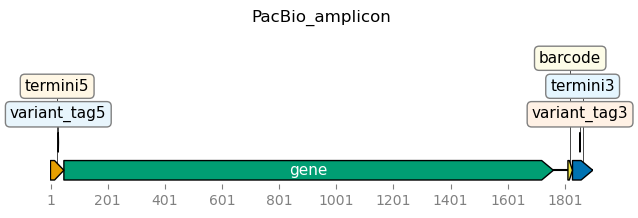

In [5]:
targets = alignparse.targets.Targets(
    seqsfile=config["pacbio_amplicon"],
    feature_parse_specs=config["pacbio_amplicon_specs"],
)

fig = targets.plot(
    ax_width=7,
    plots_indexing="genbank",
    ax_height=2,
    hspace=1.2,
)

## Why were some CCSs filtered?
Plot the number of CCSs filtered for each reason:

In [6]:
# CSVs holding filtered reads
filtered_csvs = pd.concat(
    [
        (
            pd.read_csv(os.path.join(row.subdir, "filtered.csv")).assign(
                pacbioRun=row.pacbioRun, library=row.library
            )
        )
        for row in pacbio_runs.itertuples()
    ],
    ignore_index=True,
)

# details for all filtered reads
filtered = pd.concat(
    [
        pd.read_csv(row.csv_file).assign(
            target=row.target, pacbioRun=row.pacbioRun, library=row.library
        )
        for row in filtered_csvs.itertuples()
    ],
    ignore_index=True,
)

# count reasons for filtering, then add number of non-filtered
filtered_reasons = pd.concat(
    [
        filtered.groupby(["pacbioRun", "filter_reason"], as_index=False).aggregate(
            count=pd.NamedAgg("query_name", "count")
        ),
        readstats.query('category.str.startswith("aligned")', engine="python")
        .groupby("pacbioRun", as_index=False)
        .aggregate({"count": "sum"})
        .assign(filter_reason="aligned"),
    ]
).assign(
    total_counts=lambda x: x.groupby("pacbioRun")["count"].transform("sum"),
    frac_counts=lambda x: x["count"] / x["total_counts"],
)

# make chart
filtered_chart = (
    alt.Chart(filtered_reasons)
    .encode(
        x="count:Q",
        y=alt.Y(
            "filter_reason:N",
            axis=alt.Axis(title=None),
        ),
        color="is_aligned:N",
        tooltip=filtered_reasons.columns.tolist(),
        facet=alt.Facet("pacbioRun:N", columns=2, title=None),
    )
    .mark_bar()
    .properties(width=250, height=75)
    .resolve_scale(x="independent", y="independent")
    .transform_filter(alt.datum.frac_counts > 0.01)
    .transform_calculate(is_aligned=alt.datum.filter_reason == "aligned")
)

filtered_chart

alt.Chart(...)

## Get CCSs that align to the amplicon

In [7]:
# CSVs holding aligned reads
aligned_csvs = pd.concat(
    [
        (
            pd.read_csv(os.path.join(row.subdir, "aligned.csv")).assign(
                pacbioRun=row.pacbioRun, library=row.library
            )
        )
        for row in pacbio_runs.itertuples()
    ],
    ignore_index=True,
)

assert aligned_csvs["target"].nunique() == 1

aligned = pd.concat(
    [
        (
            pd.read_csv(row.csv_file)
            .assign(pacbioRun=row.pacbioRun, library=row.library)
            .drop(columns=["query_clip5", "query_clip3"])
            .rename(columns={"barcode_sequence": "barcode"})
        )
        for row in aligned_csvs.itertuples()
    ],
    ignore_index=True,
)
print(f"\nRead {len(aligned):.4g} alignable CCSs:")
display(
    aligned.groupby("pacbioRun").aggregate(n_CCSs=pd.NamedAgg("query_name", "count"))
)
output_csv = "results/process_ccs/CCSs_aligned_to_amplicon.csv"
print(f"Writing to {output_csv}")
aligned.to_csv(output_csv, index=False)


Read 4.347e+06 alignable CCSs:


,n_CCSs
pacbioRun,
LibA-221107,3102720
LibB-221107,1243877


Writing to results/process_ccs/CCSs_aligned_to_amplicon.csv
